# Food 101 challenge summary
Food-101 is a challenging vision problem, but everyone can relate to it.  Recent SoTA is ~80% top-1, 90% top-5.  These approaches rely on lots of TTA, large networks and  even novel architectures.

Train a decent model >85% accuracy for top-1 for the test set, using a ResNet50 or smaller network with a reasonable set of augmentations.

Recognizing food is a challenging problem for computer vision. The same dish can appear very differently on image, due to several factors like variation in recipe, lighting, spatial layout. At the same time, different dishes can look very much alike due to their similar color, texture, ingredients.  

## Current state of the art

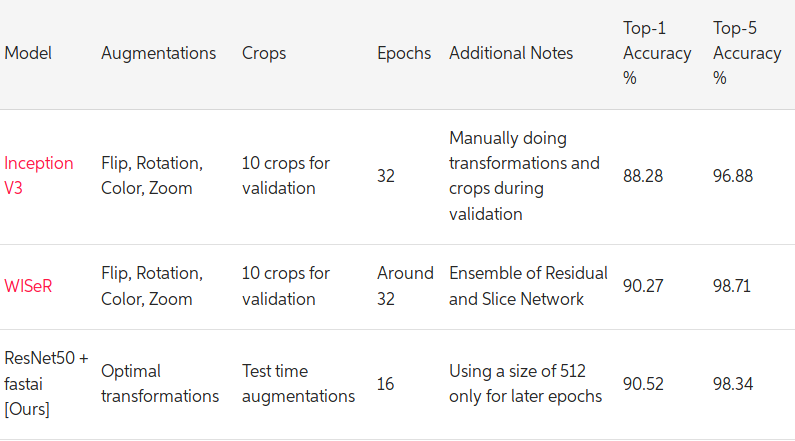
(https://platform.ai/blog/page/3/new-food-101-sota-with-fastai-and-platform-ais-fast-augmentation-search/)

<br>

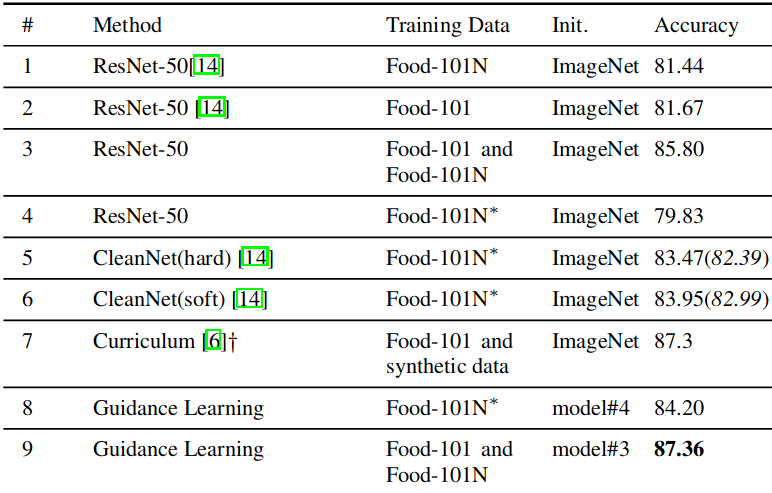
(https://arxiv.org/pdf/1907.11384.pdf)

In [ ]:
import os
import random
import shutil

from pathlib import Path
import urllib

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from fastai.vision import *

In [ ]:
# plt.style.use('dark_background')

In [ ]:
# Input root directory
input_root_dir = "../input/food-101/food-101/food-101"
input_root_path = Path(input_root_dir)
print(os.listdir(input_root_dir))

In [ ]:
# Image directory categories
input_image_path = input_root_path/'images'
image_categories = os.listdir(input_image_path)
image_categories.remove('.DS_Store')

# Peek at the categories and their total number
print(image_categories)
print(len(image_categories))

In [ ]:
# Peek inside the meta directory
os.listdir(input_root_path/'meta')

In [ ]:
# Contruct a pandas DataFrame from the given meta file, storing the filepath, category, train/validation set
def get_df_from_file(file_path, is_valid):   
    img_df = pd.read_csv(file_path, sep=';', names=['raw_txt'])
    # Append .jpg extension to all file names
    img_df['full_file_name'] = img_df['raw_txt'] + '.jpg'
    
    regex_pattern = r'(.+)\/(.+)'
    # Format of each line in input file is: category/filename, so extract accoding to this pattern
    extracted_df = img_df['full_file_name'].str.extract(regex_pattern)
    extracted_df.columns = ['category', 'file_name']

    # Join extracted values and set is_valid
    img_df = pd.DataFrame.join(img_df, extracted_df)
    img_df['is_valid'] = is_valid
    return img_df

# Load data of the train set
train_txt_file_path = (input_root_path.joinpath('meta', 'train.txt'))
train_df = get_df_from_file(train_txt_file_path, False)
print(train_df.shape)

# Load data of the validation set
test_txt_file_path = (input_root_path.joinpath('meta', 'test.txt'))
test_df = get_df_from_file(test_txt_file_path, True)
print(test_df.shape)

# Concatenate train and test sets.
image_df = pd.concat([train_df, test_df])
display(image_df.sample(10))
print(image_df.shape)

# 75750 entries in train and 25250 entries in test

## Visualize image transformation

In [ ]:
# Visualize transforms separately on a random image
def display_transform(img_df, transform, min_value, max_value, columns, width, height):
    # Sample an image from the whole dataset
    sample_file_name = img_df.sample(1)['full_file_name'].iloc[0]
    img = open_image(input_image_path/sample_file_name)
    img.show(title=sample_file_name + ' - ' + str(transform))
    
    fig, axes = plt.subplots(1, columns, figsize=(width,height))
    
    # Visualize different level of variation
    for value, axis in zip(np.linspace(min_value, max_value, columns), axes):
        img = open_image(input_image_path/sample_file_name)
        transform(img, value).show(ax=axis, title=f'value={value:.4f}')
        
display_transform(image_df, brightness, 0.5 - 0.2, 0.5 + 0.2, 6, 20, 14)
display_transform(image_df, contrast, 1 - 0.4, 1 + 0.2, 6, 20, 14)
display_transform(image_df, squish,1 - 0.3, 1 + 0.5, 6, 20, 14)

In [ ]:
# Displaying skew requires a different logic than the other transforms
def display_extra_transform(img_df, rows, columns, width, height):
    sample_file_name = img_df.sample(1)['full_file_name'].iloc[0]
    img = open_image(input_image_path/sample_file_name)
    img.show(title=sample_file_name)

    fig, axs = plt.subplots(rows, columns, figsize=(width,height))
    for i, ax in enumerate(axs.flatten()):
        open_image(input_image_path/sample_file_name).skew(i, 0.7).show(ax=ax, title=f'direction={i}')

display_extra_transform(image_df, 2, 4, 16, 8)

There are some extreme transformation cases. However, during training, these extremes should be attenuated by randomization.
At the same time, the dataset also contains extreme examples (e.g. very dark, very low contrast). We should let the model see more extreme cases, so it will have a better chance of performing well in practice.

In [ ]:
# Display all random transforms combined on the same random image
image_transforms = get_transforms(
    max_rotate=10,
    max_zoom=1.1,
    max_lighting=None,
    max_warp=0.2,
    xtra_tfms=[
        brightness(change=(0.5-0.2, 0.5+0.2), p=0.75),
        contrast(scale=(1-0.4, 1+0.2), p=0.75),
        squish(scale=(1-0.3, 1+0.5), p=0.75),
        skew(direction=(0, 7), magnitude=random.randint(0,6)/10, p=0.75),
    ]
)

def display_transforms(img_df, rows, columns, width, height, img_transforms):
    sample_file_name = img_df.sample(1)['full_file_name'].iloc[0]
    img = open_image(input_image_path/sample_file_name)
    img.show(title=sample_file_name)
    
    fig, axes = plt.subplots(rows, columns, figsize=(width, height))
    
    for row in range(rows):
        for axis in axes[row]:
            transformed_img = img.apply_tfms(img_transforms[0])
            transformed_img.show(ax=axis)

display_transforms(image_df, 3, 5, 24, 16, image_transforms)

In [ ]:
# Define transforms used for data augmentation
# By default, only horizontal flip is used, not vertical flip
# Disable default lighting alteration, and use brightness and constrast for finer control
image_transforms = get_transforms(
    max_rotate=10,
    max_zoom=1.1,
    max_lighting=None,
    max_warp=0.2,
    xtra_tfms=[
        brightness(change=(0.5-0.2, 0.5+0.2), p=0.75),
        contrast(scale=(1-0.4, 1+0.2), p=0.75),
        squish(scale=(1-0.3, 1+0.5), p=0.75),
        skew(direction=(0, 7), magnitude=random.randint(0,6)/10, p=0.75),
    ]
)

In [ ]:
# Loading image to a ImageList from path in DataFrame
split_and_labeled_images = (ImageList.from_df(
    image_df, 
    input_image_path,
    cols='full_file_name',    
))

# Split image into train and validation set based on the is_valid column
split_and_labeled_images = split_and_labeled_images.split_from_df(col='is_valid')

# Label images based on category column
split_and_labeled_images = split_and_labeled_images.label_from_df(cols='category')

print(split_and_labeled_images)

There are 75750 images in the train set and 25250 in the validation set.
The images have 3 color channels and are of various sizes

In [ ]:
image_batch_size = 64
transform_image_size = (256, 256)

# Set transform, final size and resize method
# Normalize with ImageNet stats, because the chosen model will be ResNet pre-trained with ImageNet
image_data_bunch = (
    split_and_labeled_images.transform(
        image_transforms, 
        size=transform_image_size, 
        resize_method=ResizeMethod.SQUISH)
    .databunch(bs=image_batch_size)
    .normalize(imagenet_stats)
)

# Peek inside the DataBunch
# It contains images of size 256 x 256 with 3 color channels
print(image_data_bunch)

We still have the same train and validation sets. The images still have 3 color channels, but all of them have been resized to 256 x 256

In [ ]:
# Check the categories and their total count
print(image_data_bunch.classes)
print(len(image_data_bunch.classes))
print(image_data_bunch.c)

In [ ]:
# Visualize some images, with transforms applied randonmly
image_data_bunch.show_batch(rows=4, figsize=(20,14))

## How does CNN work?

<img src="https://brohrer.github.io/images/cnn3.png" width="600">
(https://brohrer.github.io/how_convolutional_neural_networks_work.html)

Convolutions look for pieces of features in the image. In the figure above, we can see that the CNN is trying to match the green, orange and violet pieces between 2 pictures. Then, after several examples, the CNN can learn to detect patterns and small pieces of features.

A CNN consists of a chain of several convolution layers. The outputs of lower level layers become the inputs of higher level layers.

<img src="https://brohrer.github.io/images/cnn18.png" width="600">
(http://web.eecs.umich.edu/~honglak/icml09-ConvolutionalDeepBeliefNetworks.pdf)

Lower level convolutions pick up simple features like edges, basic shape. Higher level convolutions take these simple features and combine them to form more and more complex features. In the illustration above, we can see that lines and circles are combined to form eyes, noses, mouths, which then are combined to form human faces.

## What is ResNet?

<img src="http://cs231n.github.io/assets/nn1/layer_sizes.jpeg" width="600">
(http://cs231n.github.io/neural-networks-1/#arch)

The deeper a neural network is, the more complex patterns it can capture.
At the same time, a deeper network is also more prone to overfitting.


<img src="http://teleported.in/post_imgs/12-deepnet-errors.png" width="600">
(https://arxiv.org/abs/1512.03385)

However, something strange happens when we compare a deeper network (56 layers) with a shallower network (20 layers) in practice.
The deeper network is expected to overfit and have lower training error, but the opposite happens.

The idea behind ResNet is to create a deeper network that performs at least equally well as a shallower network.


<img src="http://teleported.in/post_imgs/12-residual-net.png" width="600">
(https://arxiv.org/abs/1512.03385)

The figure above illustrates the core concept of ResNet: Skip Connection. Here, instead of simply using the activation of the layer (F(x)), we add the input (x) to the activation (F(x) + x) to form the new output of the layer.
If the weights of this layer are all 0 (F(x) = 0), then this is simply an identity mapping. The input can skip through unchanged.
Thus, the deeper network has a way of adjusting itself to become the equivalent of the shallower network.


<img src="https://raw.githubusercontent.com/hiromis/notes/master/lesson7/9.png" width="600">
(https://arxiv.org/pdf/1712.09913.pdf)

It turns out that, the Skip Connections are extremely helpful by making the loss surface much smoother, thus much easier to optimize.

Since then, ResNet is widely used. Models built with ResNet usually train fast and perform well.

https://mlperf.org/training-overview/#overview

https://mlperf.org/inference-overview/#overview

In [ ]:
# Start of training

In [ ]:
# Leverage transfer learning from a ResNet50 pre-trained with ImageNet

image_learner = cnn_learner(
    image_data_bunch,
    models.resnet50,
    metrics=accuracy,
    wd=1e-1,
)

# Change the output directory to the current working directory
image_learner.model_dir = os.getcwd()
image_learner.path = Path(os.getcwd())

# Display model architecture
# image_learner.model

## How do we choose learning rates?

If the learning rate is too slow, training will take a lot of time.
If the learning rate is too high, we will be jumping around the minimum loss, getting farther and farther from the minimum and never reach it.

So to start the experiment of finding a learning rate, we train the model while increasing the learning rate. Then we plot the loss against the learning rate, and stop when the loss starts to explode.

In [ ]:
# Finding a good learning rate

image_learner.lr_find()
image_learner.recorder.plot()

Then, we divide the training into 2 parts of a cycle.
In the 1st part, we gradually increase the learning rate to a maximum value.
In the 2nd part, we gradually decrease the learning rate.
The learning rate and momentum are plotted below. For more explanations, please see the paragraph following the plot.

In [ ]:
last_block_lr = 1e-2

# Train with 1 cycle policy

image_learner.fit_one_cycle(7, slice(last_block_lr))
image_learner.save('stage1-resnet50-size256', return_path=True)

# More explanations about the different settings for learning rate in fit one cycle are here:
# https://github.com/hiromis/notes/blob/master/Lesson5.md

In [ ]:
# Now unfreeze the pre-trained part.
image_learner.unfreeze()

In [ ]:
# We need another learning rate for the unfrozen model
image_learner.lr_find()
image_learner.recorder.plot()

The pre-trained part should have a smaller learning rate, so that the weights only vary a little.
If the learning rate for the pre-trained part is too high, we risk losing what the model has learned.

Meanwhile, the not-pre-trained part should have a higher learning rate, so it will converge faster.

In [ ]:
# Still using the 1 cyle policy, but with discriminative learning rate

image_learner.fit_one_cycle(7, slice(1e-4, last_block_lr/5))
image_learner.export(os.path.join(os.getcwd(), 'stage2-resnet50-size256-export.pkl'))
image_learner.save("stage2-resnet50-size256", return_path=True)

In [ ]:
# Plot loss history
image_learner.recorder.plot_losses()

This is typical loss evolution shape, due to the 1 cycle policy.
Loss increases at first, while the learning rate cycle is in the upward phase.
Then loss decreases in the downward phase of the learning rate cycle, as we are now closer to the optimum range.

In [ ]:
# Plot the cycle of learning rate and momentum
image_learner.recorder.plot_lr(show_moms=True)

In the 1st half of the cycle, by combining a higher learning rate with a lower momentum, we encourage the model to explore a wider area of the whole loss surface. This leads to a better generalization of the model, and reduces the chance of overfitting.
Then in the 2nd half of the cycle, we are already in a generally good area of the loss surface. Therefore, we decrease the learning rate and increase the momentum to help the model find a local minimum of that area.

(For more information, [this article](https://sgugger.github.io/the-1cycle-policy.html) explains the approach suggested in [this paper](https://arxiv.org/abs/1803.09820))



In [ ]:
# Plot metrics history 
image_learner.recorder.plot_metrics()

In [ ]:
# End of training

In [ ]:
print(image_learner.metrics)

In [ ]:
# Check the final validation accuracy
image_learner.validate()

Here is the description of the validate function from the [fast.ai documentation of validate](https://docs.fast.ai/basic_train.html#Learner.validate)
> Return the calculated loss and the metrics of the current model on the given data loader dl

Our chosen metric is accuracy.

The accuracy here is the top 1 accuracy for the test set, as specified in the meta files of the dataset.
Below is an explaining example from the [fast.ai documentation of accuracy](https://docs.fast.ai/metrics.html#accuracy)

In [ ]:
ys = tensor([1], [0], [1], [0], [1])
preds = tensor([0.4, 0.6], [0.3, 0.7], [0.2, 0.8], [0.6, 0.4], [0.9, 0.1]) # bs = 5, n = 2
print(accuracy(preds, ys))

Here we have 5 actual labels (ys) and 5 predictions (preds) for a binary classification problems. 
The actual labels contain the target classes (0 and 1)
The predictions contain probabilities for each of the classes in order.

For example: the 1st prediction shows a probability of 0.4 for class 0 and 0.6 for class 1.
The model simply picks the class with the highest probability (argmax function). Class 1 has the highest probability here (0.6).
The corresponding actual label for this prediction is 1. Thus, this is counted as a good prediction.

There are 2 other good predictions in this series: the 3rd prediction [0.2, 0.8] which matches class 1, and the 4th prediction [0.6, 0.4] which matches class 0.

As a consequence, the accuracy is computed as 3 good predictions over 5 predictions in total, which gives 0.6 (3/5).

In [ ]:
# Visualize a few results
image_learner.show_results()

In [ ]:
# Some useful interpretation
interpreter = ClassificationInterpretation.from_learner(image_learner)

In [ ]:
# Display the most confused categories, min_val = error threshold for display
interpreter.most_confused(min_val=10)

In [ ]:
# Display the top losses
interpreter.plot_top_losses(12, figsize=(24,16), heatmap=True)

In [ ]:
# Start of inference test

In [ ]:
# Create a test directory to hold downloaded image
test_image_dir = Path.cwd().joinpath('test')
test_image_dir.mkdir(parents=True, exist_ok=True)
print(os.listdir(os.getcwd()))

Now, we test the model by getting an image from the Internet. Then we feed the test image to the model, and get the top 5 predictions.

In [ ]:
# Return the top prediction with descending probabilities
def get_top_predictions(img_learner, img, top_n=5):
    prediction = img_learner.predict(img)
    probabilities = prediction[2]
    partitioned_indexes = np.argpartition(probabilities, -top_n)
    top_probability_indexes = partitioned_indexes[-top_n:]
    
    top_probabilities = probabilities[top_probability_indexes]
    sorted_meta_indexes = np.argsort(top_probabilities)
    sorted_top_indexes = top_probability_indexes[sorted_meta_indexes]
    sorted_top_probabilities = probabilities[sorted_top_indexes].numpy()[::-1]
    
    class_nparray = np.array(img_learner.data.classes)
    sorted_classes = class_nparray[sorted_top_indexes][::-1]
    
    return sorted_classes, sorted_top_probabilities

# Get an image from a url and return the top predictions in descending order
def display_and_predict(img_learner, img_url, test_img_dir):
    urllib.request.urlretrieve(img_url, test_img_dir/'test1.jpg')
    test_image = open_image(test_img_dir/'test1.jpg')
    test_image.show()

    top_clss, top_proba = get_top_predictions(img_learner, test_image, top_n=5)
    return top_clss, top_proba

test_image_url = 'https://tmbidigitalassetsazure.blob.core.windows.net/secure/RMS/attachments/37/1200x1200/Triple-Chocolate-Mousse-Torte_EXPS_SDAM18_212092_C11_29_2b.jpg'
test_top_classes, test_top_probabilities = display_and_predict(image_learner, test_image_url, test_image_dir)

for label, probability in zip(test_top_classes, test_top_probabilities):
    print("{:f} {:s}".format(probability, label))

## Custom test
This custom test set contains images from a Google Images search of 101 categories.
The images are the 1st 20 results of Google Images search with the category name as keyword.

This additional test will verify the result of the validation step earlier.

In [ ]:
zip_filepath = '../input/food-101-custom-test-creation-v2/food101-custom-test-homemade-and-keyword.zip'

custom_test_image_dir = os.path.join((os.getcwd()),'custom-test')
shutil.unpack_archive(zip_filepath, custom_test_image_dir)
print(os.listdir(os.path.join(custom_test_image_dir,'cheesecake')))

In [ ]:
# Images from Google often have high contrast and brightness. Therefore, transform should reduce contrast and brightness to create more variation
custom_test_image_transforms = get_transforms(
    max_rotate=10,
    max_zoom=1.1,
    max_lighting=None,
    max_warp=0.2,
    xtra_tfms=[
        brightness(change=(0.5-0.4, 0.5), p=0.5),
        contrast(scale=(1-0.6, 1), p=0.5),
        squish(scale=(1-0.3, 1+0.5), p=0.5),
        skew(direction=(0, 7), magnitude=random.randint(0,6)/10, p=0.5),
    ]
)

In [ ]:
# All images are considered as train data for now. They will be switched later to validation
custom_test_data = (ImageList.from_folder(custom_test_image_dir)
                    .split_none()
                    .label_from_folder()
                    .transform(custom_test_image_transforms, size=(256, 256), resize_method=ResizeMethod.SQUISH)
                    .databunch()
                    .normalize(imagenet_stats)
                   )
print(custom_test_data)

In [ ]:
custom_test_data.show_batch(rows=5, figsize=(20,14))

In [ ]:
# Keep a reference to the old training & validation data.
# Swap the old data with the new custom test data
old_data = image_learner.data
image_learner.data = custom_test_data

In [ ]:
image_learner.validate(image_learner.data.valid_dl)

In [ ]:
image_learner.show_results(ds_type=DatasetType.Valid)

In [ ]:
custom_test_interpreter = ClassificationInterpretation.from_learner(image_learner)

In [ ]:
custom_test_interpreter.most_confused()

In [ ]:
custom_test_interpreter.plot_top_losses(16, figsize=(24,16), heatmap=True)

In [ ]:
# Remove unzipped images due to output file number restriction
shutil.rmtree(custom_test_image_dir, ignore_errors=True)

## Further improvements

Try Test Time Augmentation <br><br>
Experiment with other model architectures <br>
https://devpost.com/software/food101-classification<br>


Tune further the parameters for image transformations <br><br>
Progressively resize images while training (1st, train with smaller images (256x256), then train with bigger image (512x512). This might go beyond the kernel running time limit of Kaggle) <br>


Validate and inspect with other similar dataset <br>
http://visiir.lip6.fr/#demo <br>
https://www.groundai.com/project/foodx-251-a-dataset-for-fine-grained-food-classification/1 <br>
https://kuanghuei.github.io/Food-101N/ <br>